In [1]:
# initially, I will look inspect the US used car sales market; this will serve as a process roadmap for the Canada EDA
# ideally, it would be nice to find the original MSRP adjusted for inflation for every model vehicle since 1980 along
# with annual sales data to broaden the context of this analysis, but that appears to be very cumbersome; and frankly, 
# the data is too sporadic and possibly inaccurate

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from collections import Counter

df_us = pd.read_csv('us-dealers-used.csv')
df_us.head(5)

/Users/alexanderblaies/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,38b2f52e-8f5d,1GCWGFCF3F1284719,20998.0,115879.0,W1T503168C,2015.0,Chevrolet,Express Cargo,Work Van,Cargo Van,...,RWD,Automatic,E85 / Unleaded,4.8,V,nissan ellicott city,8569 Baltimore National Pike,Ellicott City,MD,21043
1,97ba4955-ccf0,WBY7Z8C59JVB87514,27921.0,7339.0,P33243,2018.0,BMW,i3,s,Hatchback,...,RWD,Automatic,Electric / Premium Unleaded,0.6,I,hendrick honda pompano beach,5381 N Federal Highway,Pompano Beach,FL,33064
2,be1da9fd-0f34,ML32F4FJ2JHF10325,11055.0,39798.0,WM2091A,2018.0,Mitsubishi,Mirage G4,SE,Sedan,...,FWD,Automatic,Unleaded,1.2,I,russ darrow toyota,2700 West Washington St.,West Bend,WI,53095
3,84327e45-6cb6,1GCPTEE15K1291189,52997.0,28568.0,9U2Y425A,2019.0,Chevrolet,Colorado,ZR2,Pickup,...,4WD,Automatic,Diesel,2.8,I,young kia,308 North Main Street,Layton,UT,84041
4,cde691c3-91dd,1G2AL18F087312093,NaN,188485.0,T36625A,2008.0,Pontiac,G5,Base,Coupe,...,FWD,Automatic,Unleaded,2.2,I,pappas toyota,10011 Spencer Rd,Saint Peters,MO,63376


In [2]:
df_us.dtypes

id               object
vin              object
price           float64
miles           float64
stock_no         object
year            float64
make             object
model            object
trim             object
body_type        object
vehicle_type     object
drivetrain       object
transmission     object
fuel_type        object
engine_size     float64
engine_block     object
seller_name      object
street           object
city             object
state            object
zip              object
dtype: object

In [3]:
# there are some columns that are trivial/redundant for my analysis; leaving seller name in the analysis will result
# in significant issues as it pertains to encoding categorical variables; zip code is too granular, as city and state are included already
df_us = df_us.drop(['id','vin','stock_no','street','seller_name','zip','city'], axis = 1)

In [4]:
# need to investigate the null rows after removing the null values for price
# want to use a pipeline for imputation (chain the imputation and modelling on the training data) - including CV and GridSearch within the pipeline
# this approach minimizes the data leakage;
df_us_na = df_us.isnull().sum().sort_values(ascending=False).reset_index()
df_us_na.columns = ['category','summation']
df_us_na['percentage_missing %'] = round(df_us_na['summation']/len(df_us) * 100, 2)
# could've used (normalize = True)
print(df_us_na)

        category  summation  percentage_missing %
0          price     656779                  9.24
1   engine_block     107110                  1.51
2    engine_size     103266                  1.45
3          miles      67290                  0.95
4      fuel_type      45956                  0.65
5   vehicle_type      38366                  0.54
6      body_type      27978                  0.39
7     drivetrain      15921                  0.22
8           trim      15169                  0.21
9   transmission      13600                  0.19
10         state      11414                  0.16
11         model       8040                  0.11
12          year        160                  0.00
13          make          0                  0.00


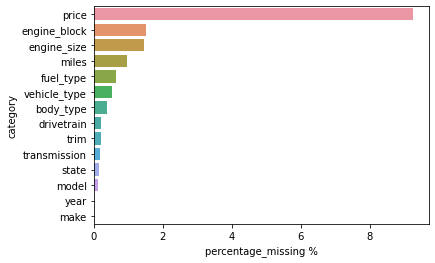

In [5]:
# confirming that the null prices have been dropped; it looks like I still have quite a few columns to inspect for imputation
df_us_na2 = df_us.isnull().sum().sort_values(ascending=False).reset_index()
df_us_na2.columns = ['category','summation']
df_us_na2['percentage_missing %'] = round(df_us_na2['summation']/len(df_us) * 100, 2)
_ = sns.barplot(x = 'percentage_missing %', y = 'category', data = df_us_na2)
plt.show()

In [6]:
# Because I am trying to predict price (dependent variable), I will remove the null values for price and investigate the other
# variables (ouch!)
df_us2 = df_us.dropna(subset=['price'])

In [7]:
df_us2.describe()
# not much to interpret here; mean for the year of car sold is 2016; 
# mean mileage is about 53000 miles; mean price is about 27.8k

,price,miles,year,engine_size
count,6.447525e+06,6.412261e+06,6.447448e+06,6.368115e+06
mean,2.786467e+04,5.291229e+04,2.016583e+03,3.086012e+00
std,1.831499e+04,4.371271e+04,3.521635e+00,1.335413e+00
min,0.000000e+00,0.000000e+00,1.980000e+03,6.000000e-01
25%,1.699900e+04,2.249000e+04,2.015000e+03,2.000000e+00
50%,2.450000e+04,3.937400e+04,2.018000e+03,2.500000e+00
75%,3.499500e+04,7.439100e+04,2.019000e+03,3.600000e+00
max,1.499996e+06,3.000000e+06,2.022000e+03,3.000000e+01


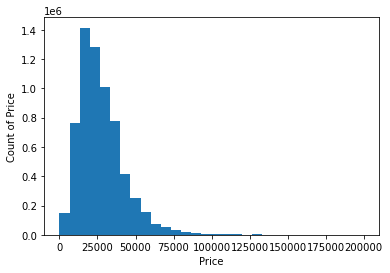

   25th Percentile  50th Percentile  75th Percentile  95th Percentile
0          16999.0          24500.0          34995.0          55799.0


In [8]:
# obviously, there are some prices that are greater than $200,000, but I will consider those outliers, so I can get a better 
# understanding of the underlying distribution which appears to be right-skewed or lognormal
# additionally, I could just use the baked-in functionality of the .hist plot provided by matplotlib that will 
# automatically plot all features with their associated distribution, but the axis are off because of the outliers;
# also, this is good practice for me
plt.hist(x = 'price',data = df_us2, bins = 30, range=[0, 200000])
plt.xlabel('Price')
plt.ylabel('Count of Price')
plt.show()

percentiles = [25, 50, 75, 95]
price_data = list(df_us2['price'])
price_print = []
def print_percentiles(data, percentiles):
    for i in percentiles:
        price_print = np.percentile(price_data, percentiles)
        return price_print

price_result = print_percentiles(price_data, percentiles)
print(pd.DataFrame({'25th Percentile': [price_result[0]], '50th Percentile': [price_result[1]], 
                    '75th Percentile': [price_result[2]], '95th Percentile': [price_result[3]]}))

In [9]:
# breaking down % of values > 200k
greatercount = pd.DataFrame([Counter(df_us2['price'] > 200000)])
greatercount.columns = ['< 200k (%)', '> 200k (%)']
print(greatercount[0:2]/(len(df_us2))*100)

   < 200k (%)  > 200k (%)
0   99.911392    0.088608


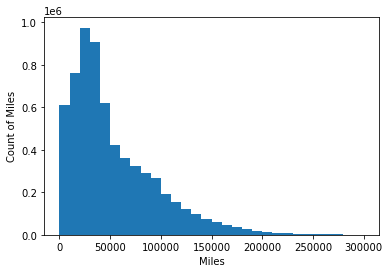

   25th Percentile  50th Percentile  75th Percentile  95th Percentile
0              NaN              NaN              NaN              NaN


In [10]:
# time to look at the mileage
# could create a class to help automate this (plotting with the percentiles)/not having to copy and paste, but for time's sake, I'll pass
plt.hist(x = 'miles',data = df_us2, bins = 30, range=[0, 300000])
plt.xlabel('Miles')
plt.ylabel('Count of Miles')
plt.show()

mileage_data = list(df_us2['miles'])
miles_print = []
def print_percentiles(data, percentiles):
    for i in percentiles:
        miles_print = np.percentile(mileage_data, percentiles)
        return miles_print

miles_result = print_percentiles(mileage_data, percentiles)
print(pd.DataFrame({'25th Percentile': [miles_result[0]], '50th Percentile': [miles_result[1]], 
                    '75th Percentile': [miles_result[2]], '95th Percentile': [miles_result[3]]}))

# well, it doesn't appreciate NaN values; how convenient 

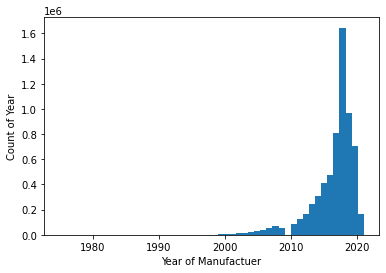

   25th Percentile  50th Percentile  75th Percentile  95th Percentile
0              NaN              NaN              NaN              NaN


In [11]:
# time to look at the year distribution
plt.hist(x = 'year',data = df_us2, bins = 50, range=[min(df_us2['year'] - 5), 2021])
plt.xlabel('Year of Manufactuer')
plt.ylabel('Count of Year')
plt.show()

annual_data = list(df_us2['year'])
annual_print = []
def print_percentiles(data, percentiles):
    for i in percentiles:
        annual_print = np.percentile(annual_data, percentiles)
        return annual_print

annual_result = print_percentiles(annual_data, percentiles)
print(pd.DataFrame({'25th Percentile': [annual_result[0]], '50th Percentile': [annual_result[1]], 
                    '75th Percentile': [annual_result[2]], '95th Percentile': [annual_result[3]]}))

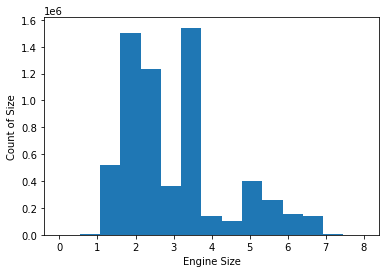

   25th Percentile  50th Percentile  75th Percentile  95th Percentile
0              NaN              NaN              NaN              NaN


In [12]:
# time to look at the engine size distribution
plt.hist(x = 'engine_size',data = df_us2, bins = 15, range=[0, 8])
plt.xlabel('Engine Size')
plt.ylabel('Count of Size')
plt.show()

engine_data = list(df_us2['engine_size'])
engine_print = []
def print_percentiles(data, percentiles):
    for i in percentiles:
        engine_print = np.percentile(engine_data, percentiles)
        return engine_print

engine_result = print_percentiles(engine_data, percentiles)
print(pd.DataFrame({'25th Percentile': [engine_result[0]], '50th Percentile': [engine_result[1]], 
                    '75th Percentile': [engine_result[2]], '95th Percentile': [engine_result[3]]}))

<AxesSubplot:>

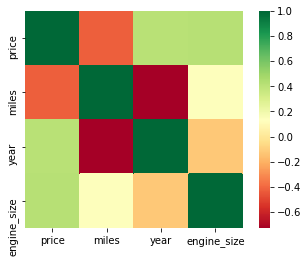

In [13]:
# initial, basic heatmap to better understand how the integers are related; after encoding/transforming the categorical variables, we 
# will take another gander at this
sns.heatmap(df_us2.corr(), square=True, cmap='RdYlGn')

# plotting some initial visualizations of key variables; as one would expect, an increase in miles, leads to a decrease in price
# the newer the car is, the more valuable it is, and the size of the engine is positively correlated to the price as well

In [14]:
# creating a column to map country of origin to each make; additionally, will create another column that maps to domestic
# or international
list_of_makes = list(df_us2['make'].unique())
print(list_of_makes)
# ensuring I have every make accoutned for; you will notice that some makes need to be renamed/remapped                

['Chevrolet', 'BMW', 'Mitsubishi', 'Dodge', 'Mercedes-Benz', 'Maserati', 'Lexus', 'RAM', 'Porsche', 'Ford', 'Mercury', 'Audi', 'Lamborghini', 'GMC', 'Alfa Romeo', 'smart', 'Jeep', 'Lincoln', 'Ferrari', 'Pontiac', 'Volvo', 'Jaguar', 'Buick', 'Scion', 'Toyota', 'Aston Martin', 'Honda', 'Saturn', 'Saab', 'Bentley', 'Land Rover', 'Chrysler', 'FIAT', 'Oldsmobile', 'Mazda', 'Cadillac', 'Volkswagen', 'Isuzu', 'Rolls-Royce', 'Subaru', 'INFINITI', 'Plymouth', 'Am General', 'Lotus', 'Hummer', 'Sterling', 'Maybach', 'Acura', 'Kia', 'Suzuki', 'Tesla', 'Nissan', 'Hyundai', 'McLaren', 'Eagle', 'MINI', 'KARMA', 'GENESIS', 'Fisker', 'Daewoo', 'Datsun', 'Geo', 'Panoz']


In [15]:
# ensuring I have every make accoutned for; you will notice that some makes need to be renamed/remapped                
# what about bringing in retail pricing? need to do some digging
country_of_origin = pd.DataFrame({'make': ['Abarth', 'Alfa Romeo', 'Aston Martin','Audi','Bentley'
                          ,'BMW','Bugatti','Cadillac','Caterham','Chery','Chevrolet','Chrysler'
                          ,'Citroen','Daewoo','Daihatsu','Datsun','Dodge','Ferrari','FIAT','Ford'
                          ,'Great Wall','Holden','Honda','Hyundai','INFINITI','Isuzu','Jaguar'
                          ,'Jeep','Kia','Lamborghini','Land Rover','LDV','Lexus','Lotus','Maserati'
                          ,'Mazda','McLaren','Mercedes-Benz','MG','MINI','Mitsubishi','Nissan','Opel'
                          ,'Peugeot','Porsche','Proton','Renault','Rolls-Royce','Saab','ŠKODA','smart'
                          ,'SsangYong','Subaru','Suzuki','Tesla','Toyota','Volkswagen','Volvo','Hummer'
                          ,'Pontiac','Fisker','GMC','RAM','Oldsmobile','GENESIS','Acura','AMC','Panoz'
                          ,'KARMA','Plymouth','Scion','Eagle','Sterling','Geo','Am General','Buick'
                          ,'Lincoln', 'Maybach', 'Mercury', 'Saturn']
                     ,'Country_Origin': ['Italy','Italy','England','Germany','England','Germany'
                          ,'France','America','England','China','America','America','France'
                          ,'South Korea','Japan','Japan','America','Italy','Italy','America','China'
                          ,'Australia','Japan','South Korea','Japan','Japan','England','America','South Korea'
                          ,'Italy','England','China','Japan','England','Italy','Japan','England','Germany'
                          ,'England','England','Japan','Japan','Germany','France','Germany','Malaysia'
                          ,'France','England','Sweden','Czech Republic','Germany','South Korea','Japan'
                          ,'Japan','America','Japan','Germany','Sweden','America','America','America'
                          ,'America','America','America','South Korea','Japan','America','America','America'
                          ,'America','Japan','America','England','America','America','America','America'
                          ,'Germany','America','America']})

In [16]:
df_us_n = pd.merge(df_us2, 
                     country_of_origin, 
                     on ='make', 
                     how ='left')

df_us_n.head(5)

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
0,20998.0,115879.0,2015.0,Chevrolet,Express Cargo,Work Van,Cargo Van,Truck,RWD,Automatic,E85 / Unleaded,4.8,V,MD,America
1,27921.0,7339.0,2018.0,BMW,i3,s,Hatchback,Car,RWD,Automatic,Electric / Premium Unleaded,0.6,I,FL,Germany
2,11055.0,39798.0,2018.0,Mitsubishi,Mirage G4,SE,Sedan,Car,FWD,Automatic,Unleaded,1.2,I,WI,Japan
3,52997.0,28568.0,2019.0,Chevrolet,Colorado,ZR2,Pickup,Truck,4WD,Automatic,Diesel,2.8,I,UT,America
4,3995.0,137537.0,2000.0,Dodge,Ram Pickup,ST,Pickup,Truck,RWD,Manual,Unleaded,5.2,V,OH,America


In [17]:
# checking to ensure we have no NaN values in the 'Country_Origin' column
print(df_us_n['Country_Origin'].isnull().sum())

0


In [18]:
# used to see which makes weren't originally included in the merge; accounted for those values ('Buick', 'Lincoln', 'Maybach', 'Mercury', 'Saturn')
m = df_us_n['Country_Origin'].isna().groupby(df_us_n['make']).all()
nan, not_nan = m[m].index.tolist(),  m[~m].index.tolist()
print(nan)

[]


In [19]:
# I'm going to add in a column that calculates the price as a function of miles; I think this would prove beneficial for my analysis
df_us_n = df_us_n.assign(price_miles = lambda x: (x['price'] / x['miles']))
# this does not add any value as initially thought; the numbers/proportions are distorted with vehicles that have extremely low miles; maybe it 
# makes sense to go ahead and compartmentalize the data into ranges/buckets with an associated value
df_us_n = df_us_n.drop(['price_miles'], axis = 1)

In [20]:
# Before I start to go more in depth with my EDA, I would like to first better understand the data and do some cleanup
# hence, where are my inconsistencies and potential erroneous entries?
# let's start with the model feature, as I've already confirmed that the make feature is good

model_cleanup = pd.DataFrame([Counter(df_us_n['model'].sort_values())])
model_cleanup = model_cleanup.transpose()
# model_cleanup.to_csv('Unique_model.csv', sep='\t') - used as a reference for expediting the replacing of values
model_cleanup.head(15)

# original length was 1204 prior to cleanup
# after inspection, it looks like there are quite a few issues: capitalization/inconsistencies regarding capitalization, 
# spacing, naming conventions, accents over the e in two different models, etc.

,0
1 Series,589
124 Spider,859
12C,56
164,2
190,1
2 Series,8052
200,14193
240,2
240d,1
2500,1


In [21]:
# applying the lowercase method via vectorization 
df_us_n['model'] = df_us_n['model'].map(lambda x: x.lower() if isinstance(x,str) else x)

In [22]:
# filtering to look at specific entries for a "head check", as it relates to replacing values
df_us_n[df_us_n['model'].str.contains('amga gt', na = False)]

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
377513,89960.0,2577.0,2021.0,Mercedes-Benz,amga gt 4-door coupe,43,Hatchback,Car,4WD,Automatic,Electric / Premium Unleaded,3.0,I,WI,Germany
390639,94999.0,226.0,2021.0,Mercedes-Benz,amga gt 4-door coupe,43,Hatchback,Car,4WD,Automatic,Electric / Premium Unleaded,3.0,I,NC,Germany
423170,164989.0,737.0,2020.0,Mercedes-Benz,amga gt 4-door coupe,63 S,Hatchback,Car,4WD,Automatic,Premium Unleaded,4.0,V,TX,Germany
1990147,94999.0,226.0,2021.0,Mercedes-Benz,amga gt 4-door coupe,43,Hatchback,Car,4WD,Automatic,Electric / Premium Unleaded,3.0,I,NC,Germany
3574608,94999.0,226.0,2021.0,Mercedes-Benz,amga gt 4-door coupe,43,Hatchback,Car,4WD,Automatic,Electric / Premium Unleaded,3.0,I,TX,Germany
3649365,168888.0,4776.0,2020.0,Mercedes-Benz,amga gt 4-door coupe,63 S,Hatchback,Car,4WD,Automatic,Premium Unleaded,4.0,V,FL,Germany
5210398,89960.0,2577.0,2021.0,Mercedes-Benz,amga gt 4-door coupe,43,Hatchback,Car,4WD,Automatic,Electric / Premium Unleaded,3.0,I,WI,Germany


In [23]:
# replacing some obvious errors; went down to 1176 unique values from 1204
df_us_n.replace({'model' : { '3-series' : '3 series', '3000gt' : '3000 gt', '5-series' : '5 series'
                          , '6-series' : '6 series', '7-series' : '7 series', 'cl' : 'cl-class'
                          , 'cl class' : 'cl-class', 'cla' : 'cla-class', 'clk' : 'clk-class', 'e-350' : 'e350'
                          , 'e-450sd' : 'e450', 'f150' : 'f-150', 'f350' : 'f-350', 'f750':'f-750','f-350sd':'f-350 super duty'
                          , 'f-450sd':'f-450 super duty', 'f-550sd':'f-550 super duty','legacy wagon' : 'legacy'
                          , 'ram pickup' : 'ram 1500 pickup', 'ram' : 'ram 1500 pickup', 'ram 1500' : 'ram 1500 pickup'
                          , 'ram 150' : 'ram 1500 pickup', 'ram 250' : 'ram 2500 pickup', 'ram pickup 2500' : 'ram 2500 pickup'
                          , 'ram 3500 cab chassis' : 'ram 3500 chassis cab', 'ram 3500' : 'ram 3500 pickup', 'ram 4500 cab chassis' : 'ram 4500 chassis cab'
                          , 'xl-7':'xl7','transit crew van':'transit passenger van'}},inplace = True)
                           
df_us_n['model'] = df_us_n.model.str.replace('[é]','e')

In [24]:
# length is now 1176 unique values
df_us_n['model'].nunique()

1176

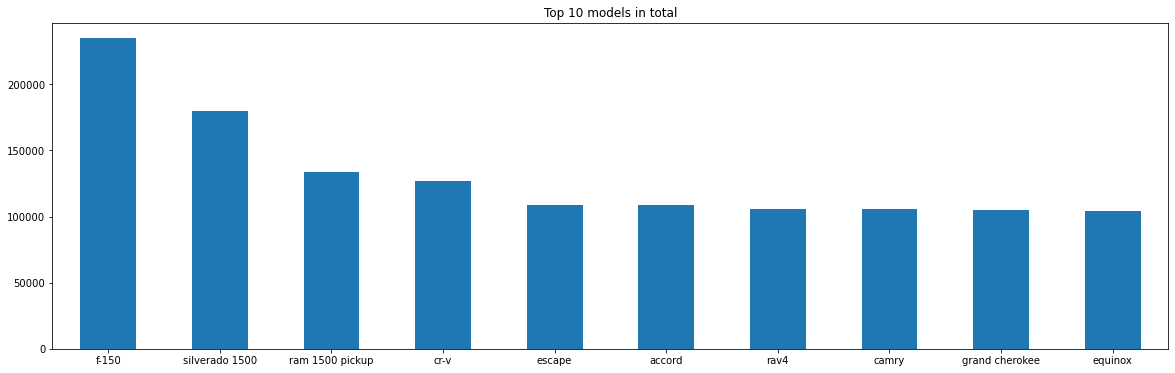

In [25]:
# visualizing the top models
df_us_n['model'].value_counts().head(10).plot.bar(figsize=(20,6),rot=0, title="Top 10 models in total")
plt.show()

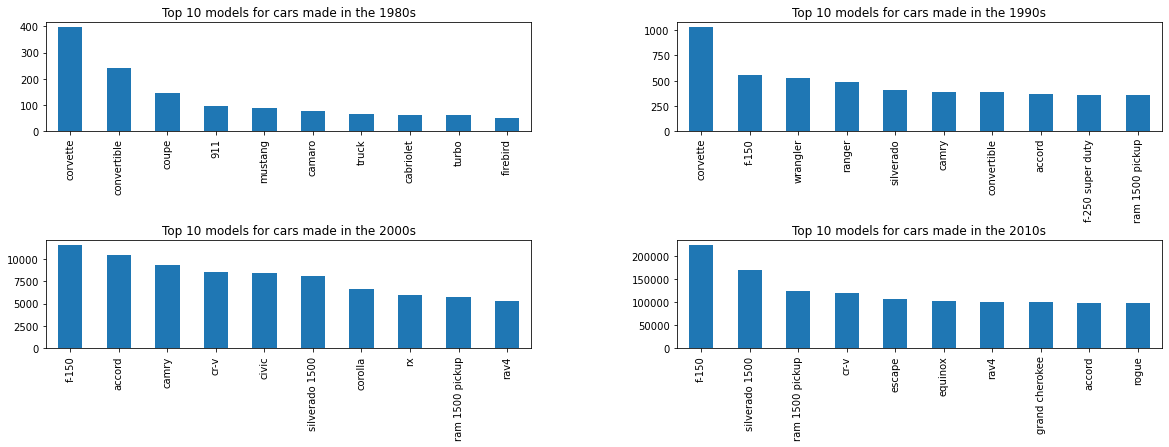

In [26]:
# how about looking at each decade (1980, 1990, 2000, 2010, 2020)

plt.subplot(2, 2, 1)
nineteen80s = df_us_n[(df_us_n['year']>=1980) & (df_us_n['year']<=1990)]
nineteen80s['model'].value_counts().head(10).plot.bar(figsize=(20,6),rot=0, title="Top 10 models for cars made in the 1980s")
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
nineteen90s = df_us_n[(df_us_n['year']>=1990) & (df_us_n['year']<=2000)]
nineteen90s['model'].value_counts().head(10).plot.bar(figsize=(20,6),rot=0, title="Top 10 models for cars made in the 1990s")
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
twothou = df_us_n[(df_us_n['year']>=2000) & (df_us_n['year']<=2010)]
twothou['model'].value_counts().head(10).plot.bar(figsize=(20,6),rot=0, title="Top 10 models for cars made in the 2000s")
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
twothouten = df_us_n[(df_us_n['year']>=2010) & (df_us_n['year']<=2020)]
twothouten['model'].value_counts().head(10).plot.bar(figsize=(20,6),rot=0, title="Top 10 models for cars made in the 2010s")
plt.xticks(rotation=90)

plt.subplots_adjust(wspace=.3, hspace=1)
plt.show()

In [27]:
# now it is time to inspect the trim feature
trim_cleanup = pd.DataFrame([Counter(df_us_n['trim'].sort_values())])
trim_cleanup = trim_cleanup.transpose()
# original length was 2342 prior to cleanup
# after inspection, it looks like there are quite a few issues: capitalization/inconsistencies regarding capitalization, 
# spacing, naming conventions, registered trademark symbol being applied by certain dealers, etc.

In [28]:
# applying the lower method to the trim column
df_us_n['trim'] = df_us_n['trim'].map(lambda x: x.lower() if isinstance(x,str) else x)
# went from 2342 to 2223.. not bad

In [29]:
df_us_n.replace({'trim' : { 'clk 320' : 'clk320', 'e 300' : 'e300', 'e 320' : 'e320', 'e 420' : 'e420'
                          , 'e 430' : 'e430', 'e320 4matic sedan' : 'e320 4matic', 'e430 sedan' : 'e430'
                          , 'ec' : 'eco', 'ed bauer' : 'eddie bauer', 'es4wd' : 'es awd'
                          , '+' : 'plus', 'ev +' : 'ev plus', 'ex w/leather' : 'ex leather'
                          , 'ex-l v-6' : 'ex-l v6', 'i l.l. bean' : 'i l.l. bean edition'
                          , 'inspiration' : 'inspiration series', 'iroc z coupe' : 'iroc z convertible'
                          , 'landmark' : 'landmark edition', 'lt entertainer' : 'lt entertainment'
                          , 'luxury edition' : 'luxury collection', 'lx 2-door sedan' : 'lx'
                          , 'm edition' : 'm', 'ml 320' : 'ml320', 'night shade' : 'nightshade'
                          , 'north' : 'north edition', 'off road' : 'off-road', 'premiere edition' : 'premiere'
                          , 'prerunner v6' : 'prerunner', 'rally' : 'rally edition', 'se 4wd' : 'se awd'
                          , 'se off road': 'se off-road', 'signature l': 'signature limited', 'sle-1':'sle1'
                          , 'sle-2':'sle2', 'srt-10':'srt10', 'srt-4':'srt4', 'srt-6':'srt6', 'srt-8':'srt8'
                          , 'st line':'st-line', 'touring-l':'touring l', 'touring-l plus':'touring l plus'
                          , 'trd off-road':'trd off road', 'type r':'type-r', 'type s':'type-s'
                          , 'uptown':'uptown edition', 'v-6':'v6', 'work series':'work', 'xl 2wd':'xl'
                          , 'z/28':'z28', 'zx2 hot':'zx2', 'amg s 63':'amg s63', 'amg s 65':'amg s65'
                          , '75th anniversary': '75th anniversary edition', '60 years edition': '60th anniversary'
                          , '50th anniversary': '50th anniversary special edition', '50th anniversary edition': '50th anniversary special edition'
                          , '50th anniversary': '50th anniversary special edition'}}, inplace = True)

df_us_n['trim'] = df_us_n.trim.str.replace('[®]','')

In [30]:
# got it down another 80 or so (2142); confirming that the registered trademark symbol has been removed
df_us_n[df_us_n['trim'].str.contains("", na = False)]
# trim_cleanup.to_csv('Unique_Trim4.csv', sep='\t')
df_us_n['trim'].nunique()

2138

In [31]:
# body type is up next; I will follow the same process as above
(Counter(df_us_n['body_type']))

Counter({'Cargo Van': 44651,
         'Hatchback': 271935,
         'Sedan': 1647324,
         'Pickup': 1022970,
         'Mini Mpv': 8665,
         'SUV': 2571582,
         'Coupe': 214676,
         'Crossover': 357545,
         'Minivan': 128578,
         'Cutaway': 1920,
         'Chassis Cab': 8831,
         'Convertible': 52760,
         'Targa': 2526,
         'Roadster': 11231,
         'Passenger Van': 6548,
         'Micro Car': 407,
         'Wagon': 73822,
         nan: 19804,
         'Van': 494,
         'Chassis Cowl': 4,
         'Commercial Wagon': 24,
         'Combi': 868,
         'Car Van': 360})

In [32]:
# the vehicle type is pretty bland; It might be worthwhile to expand on this an add in more descriptive naming conventions
# such as: sports car, van, etc.
df_us_n.vehicle_type.unique()

array(['Truck', 'Car', nan], dtype=object)

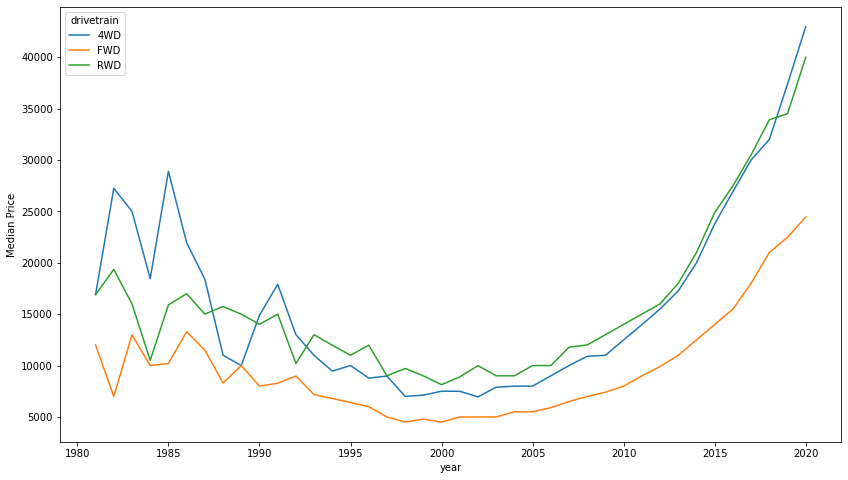

In [33]:
# inspecting the drivetrain feature
[Counter(df_us_n['drivetrain'].sort_values())]
df_train = df_us_n[['year','drivetrain','price']]
df_train = df_train[(df_train.year < 2021)]
df_train_analysis = pd.pivot_table(df_train, values='price', 
                    index='year', 
                    columns='drivetrain',
                    aggfunc='median', fill_value = 0)
df_train_analysis.plot(kind='line', figsize=(14,8))
plt.ylabel('Median Price')
plt.show()

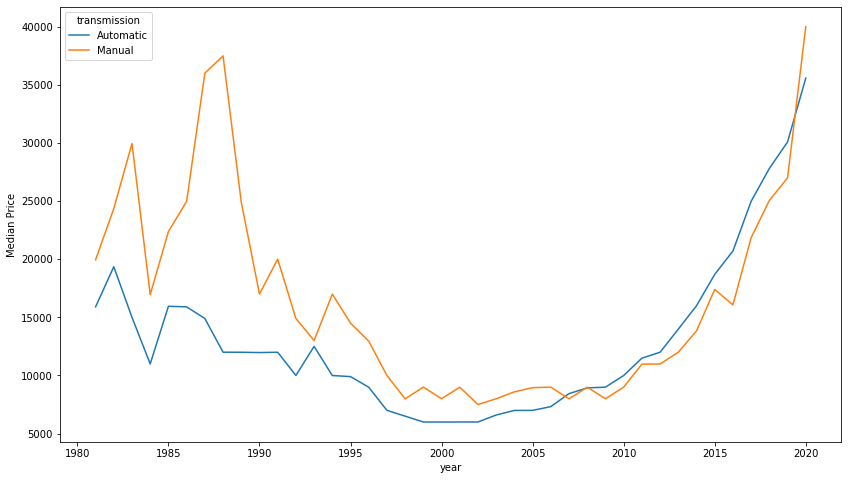

In [34]:
# inspecting the transmission feature
[Counter(df_us_n['transmission'].sort_values())]
df_trans = df_us_n[['year','transmission','price']]
df_trans = df_trans[(df_trans.year < 2021)]
df_trans_analysis = pd.pivot_table(df_trans, values='price', 
                    index='year', 
                    columns='transmission',
                    aggfunc='median', fill_value = 0)
df_trans_analysis.plot(kind='line', figsize=(14,8))
plt.ylabel("Median Price")
plt.show()

In [35]:
# let's take a look at the fuel type column; a bit off on the naming conventions
df_us_n.fuel_type.unique()

array(['E85 / Unleaded', 'Electric / Premium Unleaded', 'Unleaded',
       'Diesel', 'Premium Unleaded', 'Premium Unleaded; Unleaded', nan,
       'Electric / Unleaded', 'Unleaded; Unleaded / E85',
       'Unleaded / E85', 'E85 / Unleaded; Unleaded',
       'Premium Unleaded / Unleaded',
       'E85 / Premium Unleaded; E85 / Unleaded', 'Unleaded / Electric',
       'Compressed Natural Gas', 'E85', 'Electric',
       'E85 / Premium Unleaded', 'Electric / Hydrogen',
       'Compressed Natural Gas; Unleaded',
       'E85 / Unleaded; Unleaded / Unleaded',
       'Electric / Premium Unleaded; Electric / Unleaded',
       'Electric / Premium Unleaded; Premium Unleaded',
       'Diesel / Premium Unleaded', 'E85 / Unleaded; Unleaded / E85',
       'Unleaded / Unleaded', 'Electric / E85',
       'Compressed Natural Gas / Unleaded', 'Diesel; Unleaded',
       'Diesel; E85 / Unleaded', 'E85 / Unleaded; Premium Unleaded',
       'Premium Unleaded; Premium Unleaded / E85', 'E85; E85 / Unleaded',
  

In [36]:
# inspecting some of these less populus naming conventions, based on my observations, I will make repalcements in succeeding cell below
# after inspecting the different fuel types, I decided to go with 
# df_us_n[df_us_n['fuel_type'].str.contains('Electric / Premium Unleaded; Premium Unleaded', na = False)]

In [37]:
df_us_n.replace({'fuel_type' : { 'Compressed Natural Gas; Unleaded' : 'Compressed Natural Gas', 'Compressed Natural Gas / Unleaded' : 'Compressed Natural Gas'
                                , 'Compressed Natural Gas / Lpg' : 'Compressed Natural Gas', 'Diesel / Premium Unleaded' : 'Premium Unleaded'
                                , 'Biodiesel' : 'Diesel', 'Diesel; E85 / Unleaded' : 'Diesel', 'Diesel; Unleaded' : 'Diesel'
                                , 'E85 / Premium Unleaded' : 'Premium Unleaded', 'E85 / Premium Unleaded; E85 / Unleaded' : 'Unleaded'
                                , 'E85' : 'Unleaded', 'E85 / Unleaded; Premium Unleaded' : 'Premium Unleaded', 'E85 / Unleaded; Unleaded' : 'Unleaded'
                                , 'E85 / Unleaded; Unleaded / E85': 'Unleaded','E85 / Unleaded; Unleaded / Unleaded':'Unleaded'
                                , 'Electric / Premium Unleaded; Premium Unleaded':'Electric / Premium Unleaded'
                                , 'Electric / Premium Unleaded; Electric / Unleaded':'Electric / Premium Unleaded','Electric / E85':'Electric / Unleaded'
                                , 'M85 / Unleaded':'Unleaded','Premium Unleaded / E85':'Premium Unleaded','Premium Unleaded / Unleaded':'Premium Unleaded'
                                , 'Premium Unleaded; Premium Unleaded / E85': 'Premium Unleaded','Premium Unleaded; Unleaded':'Premium Unleaded'
                                , 'Unleaded / E85':'Unleaded','Unleaded / Premium Unleaded':'Unleaded','Unleaded / Unleaded':'Unleaded'
                                , 'Unleaded; Unleaded / E85':'Unleaded','E85; E85 / Unleaded':'Unleaded'
                                , 'Unleaded / Electric':'Electric / Unleaded','Electric / E85 / Unleaded':'Electric / Unleaded', 'Electric Unleaded': 'Electric / Unleaded'}}, inplace = True)
                                
                                

In [38]:
fuel_cleanup = pd.DataFrame([Counter(df_us_n['fuel_type'].sort_values(ascending = True))])
fuel_cleanup = fuel_cleanup.transpose().reset_index()
fuel_cleanup.rename(columns={'index':'Fuel type', 0:'Count'}, inplace = True)
fuel_cleanup.head(5)

,Fuel type,Count
0,Compressed Natural Gas,357
1,Diesel,153635
2,E85 / Unleaded,459864
3,Electric,19760
4,Electric / Hydrogen,182


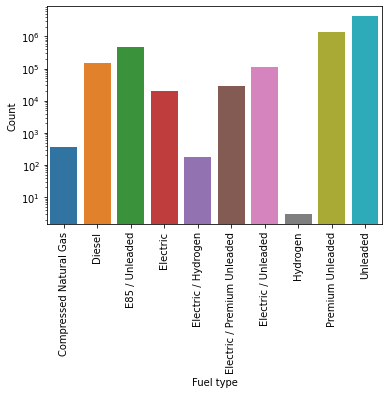

In [39]:
[Counter(df_us_n['fuel_type'].sort_values())]

_ = sns.barplot(x = 'Fuel type', y = 'Count', data = fuel_cleanup)
_.set(yscale="log")
plt.xticks(rotation=90)
plt.show()

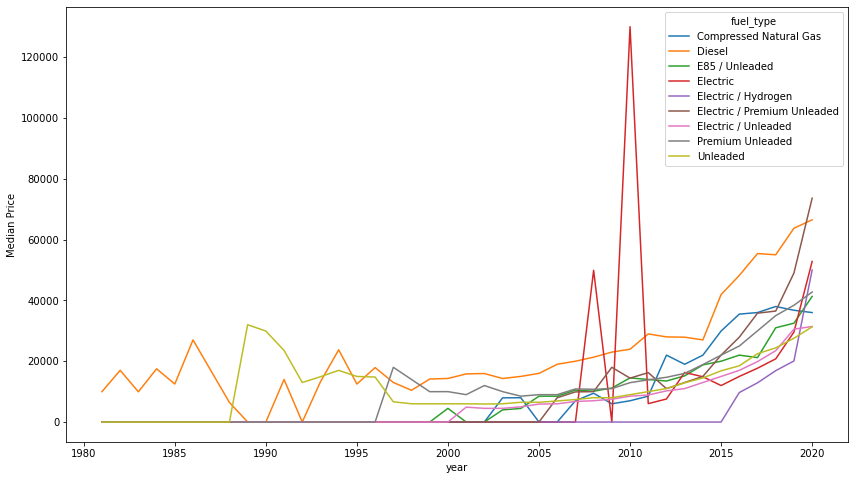

In [40]:
# what about a scatterplot analyzing the fuel type and year of manufacture?
df_con = df_us_n[['year','fuel_type','price']]
df_con = df_con[(df_con.year < 2021)]
df_fuel_type_analysis = pd.pivot_table(df_con, values='price', 
                    index='year', 
                    columns='fuel_type',
                    aggfunc='median', fill_value = 0)
df_fuel_type_analysis.plot(kind='line', figsize=(14,8))
plt.ylabel('Median Price')
plt.show()

In [41]:
# time to investigate the spikes for the 2010 and 2007-2008 electric vehicles
electric_mask = (df_us_n['fuel_type']=='Electric') & (df_us_n['year']>=2005) & (df_us_n['year']<=2009)
electric = df_us_n[electric_mask]
electric.head(5)

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
4893428,49900.0,14975.0,2008.0,Tesla,roadster,base,Roadster,Car,RWD,Automatic,Electric,NaN,NaN,CA,America


In [42]:
# looks like we only have one value for a 2008 and 2010 electric used vehicle that was sold; this makes sense, as 
# the tesla roadster is their most expensive and highly sought-after model
# additionally, it looks like we can fill all Electric cars where engine_size and engine_block = NaN with "battery"
electric_mask2 = (df_us_n['fuel_type']=='Electric') & (df_us_n['year']==2010)
electric2 = df_us_n[electric_mask2]
electric2.head(5)

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
60919,130000.0,47700.0,2010.0,Tesla,roadster,sport,Roadster,Car,RWD,Automatic,Electric,NaN,NaN,OR,America


In [43]:
# additionally, it looks like we can fill all Electric cars where engine_size and engine_block = NaN with "0";
# it's safe to go ahead and treat all electric vehicles the same; granted, the batteries could be of a different size
# but the model + trim will account for this (e.g. tesla model 3 long range)
df_us_n.loc[df_us_n['fuel_type'] == 'Electric', 'engine_block'] = 0
df_us_n.loc[df_us_n['fuel_type'] == 'Electric', 'engine_size'] = 0
df_us_n[df_us_n['fuel_type']=='Electric'].head(5)

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
46913,44590.0,33376.0,2018.0,Tesla,model 3,awd,Sedan,Car,4WD,Automatic,Electric,0.0,0,AZ,America
47032,15654.0,60048.0,2018.0,Hyundai,ioniq,base,Hatchback,Car,FWD,Automatic,Electric,0.0,0,CA,South Korea
47066,65000.0,20755.0,2018.0,Tesla,model 3,awd,Sedan,Car,4WD,Automatic,Electric,0.0,0,OR,America
47070,37990.0,12255.0,2018.0,Tesla,model 3,long range,Sedan,Car,RWD,Automatic,Electric,0.0,0,TX,America
47080,13981.0,26714.0,2014.0,BMW,i3,base,Hatchback,Car,RWD,Automatic,Electric,0.0,0,OH,Germany


In [44]:
# checking to see how many NaNs were replaced
df_us_na2 = df_us_n.isnull().sum().sort_values(ascending=False).reset_index()
df_us_na2.columns = ['category','summation']
df_us_na2['percentage_missing %'] = round(df_us_na2['summation']/len(df_us_n) * 100, 2)
print(df_us_na2)

          category  summation  percentage_missing %
0     engine_block      62749                  0.97
1      engine_size      59884                  0.93
2            miles      35264                  0.55
3        fuel_type      32295                  0.50
4     vehicle_type      28129                  0.44
5        body_type      19804                  0.31
6            state      11371                  0.18
7       drivetrain       9613                  0.15
8             trim       9473                  0.15
9     transmission       8078                  0.13
10           model       5526                  0.09
11            year         77                  0.00
12  Country_Origin          0                  0.00
13            make          0                  0.00
14           price          0                  0.00


In [45]:
# what about the engine size and engine block; is there a correlation between the two? 
df_us_n.engine_block.unique()

array(['V', 'I', 'H', nan, 0], dtype=object)

In [46]:
df_us_enginenull = df_us_n[df_us_n.engine_block.isnull()]
df_us_enginenull.head(10)

,price,miles,year,make,model,trim,body_type,vehicle_type,drivetrain,transmission,fuel_type,engine_size,engine_block,state,Country_Origin
530,7995.0,75935.0,1989.0,Chrysler,turbo,turbo,Convertible,NaN,FWD,Automatic,NaN,2.2,NaN,MI,America
659,4950.0,122000.0,2009.0,Mazda,rx-8,grand touring,Coupe,Car,RWD,Manual,Premium Unleaded,2.6,NaN,TX,Japan
1496,4995.0,119949.0,2001.0,Honda,prelude,base,Coupe,Car,FWD,Automatic,Premium Unleaded,2.2,NaN,NC,Japan
1639,7295.0,94185.0,1987.0,BMW,7 series,735i automatic,Sedan,Car,NaN,NaN,NaN,3.4,NaN,NY,Germany
3622,9500.0,29527.0,2004.0,Mazda,rx-8,- at,Coupe,Car,RWD,Automatic,Premium Unleaded,2.6,NaN,UT,Japan
3988,29000.0,111000.0,2012.0,Audi,a8,base,Sedan,Car,4WD,Automatic,Premium Unleaded,6.3,NaN,MN,Germany
4115,11873.0,79146.0,2009.0,Mazda,rx-8,grand touring,Coupe,Car,RWD,Manual,Premium Unleaded,2.6,NaN,CO,Japan
4811,27000.0,97869.0,1997.0,Dodge,truck,laramie,Pickup,Truck,4WD,Automatic,Diesel,5.9,NaN,CA,America
5058,10900.0,171039.0,2002.0,GMC,c7h064,c7h064,NaN,NaN,NaN,Manual,Diesel,7.2,NaN,TX,America
5952,10900.0,119414.0,1985.0,Jaguar,xj6,base,Sedan,Car,NaN,NaN,NaN,4.2,NaN,SC,England


In [47]:
# there was an erroneous entry for engine_size; it was 30.0, but needed to be 3.0; I replaced the respective value in the 
# succeeding cells
# well, that doesn't seem right; time to look at the other Maserati quattroporte observations
quat = pd.DataFrame(df_us_n[df_us_n['model'] == 'quattroporte'])
#quat.head(15)
np.mean(quat.engine_size)

3.370424836601304

In [48]:
# replacing the erroneous entry with 3.0 per the result from a google search
df_us_n.loc[23917,'engine_size'] = float(3.0)

In [49]:
size_block = df_us_n.groupby(['engine_size','engine_block']).size().reset_index().rename(columns={0:'count'})
# no way to intelligently impute based on the correlation between engine_size, block and manufacturer 

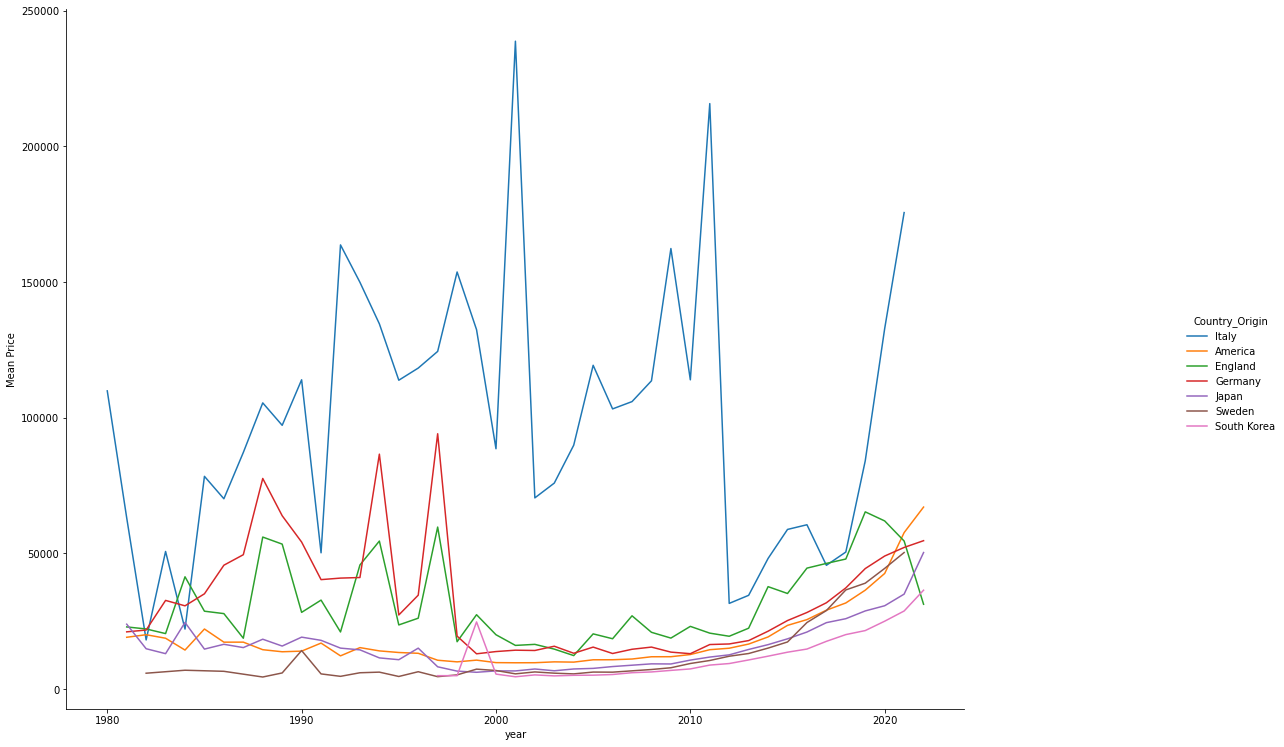

In [50]:
# manipulating the dataframe to visualize the price per make over the course of time
df_us_new_groupby = df_us_n.groupby(['year','Country_Origin']).mean()
df_us_new_groupby.head(15)

_ = sns.relplot(x="year", y="price", hue="Country_Origin", kind = "line", data=df_us_new_groupby);
#_._legend.remove()
_.fig.set_figwidth(20)
_.fig.set_figheight(11)
plt.ylabel("Mean Price")
plt.show()

# pretty messy initial look, so let's see what I can do to clean it up and compartementalize some of the info
# analyzing the data by the make/manufactuer creates a very busy visualization
# based on the graph below, it's interesting to see some spikes for certain years when considering the country of origin

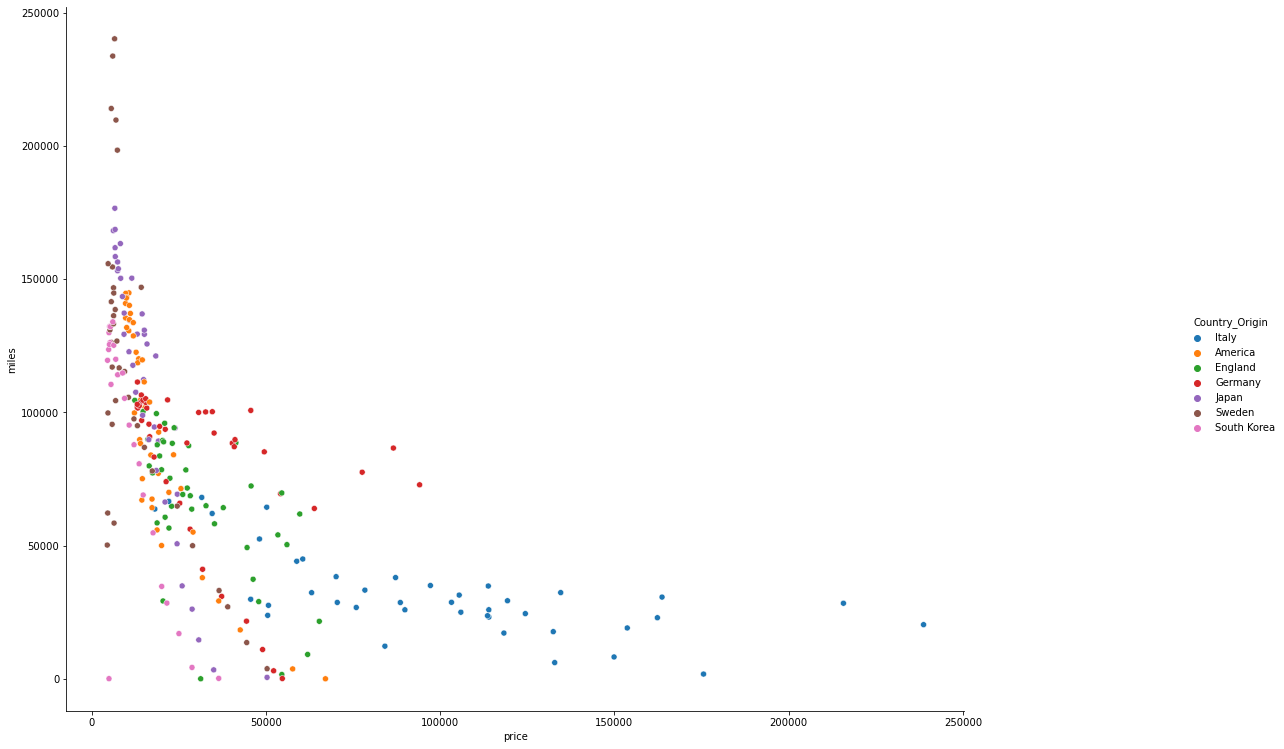

In [51]:
# plotting price v miles based on the country_origin; let's now consider some makes
_ = sns.relplot(x="price", y="miles", hue="Country_Origin", kind = "scatter", data=df_us_new_groupby)
_.fig.set_figwidth(20)
_.fig.set_figheight(11)
plt.show()

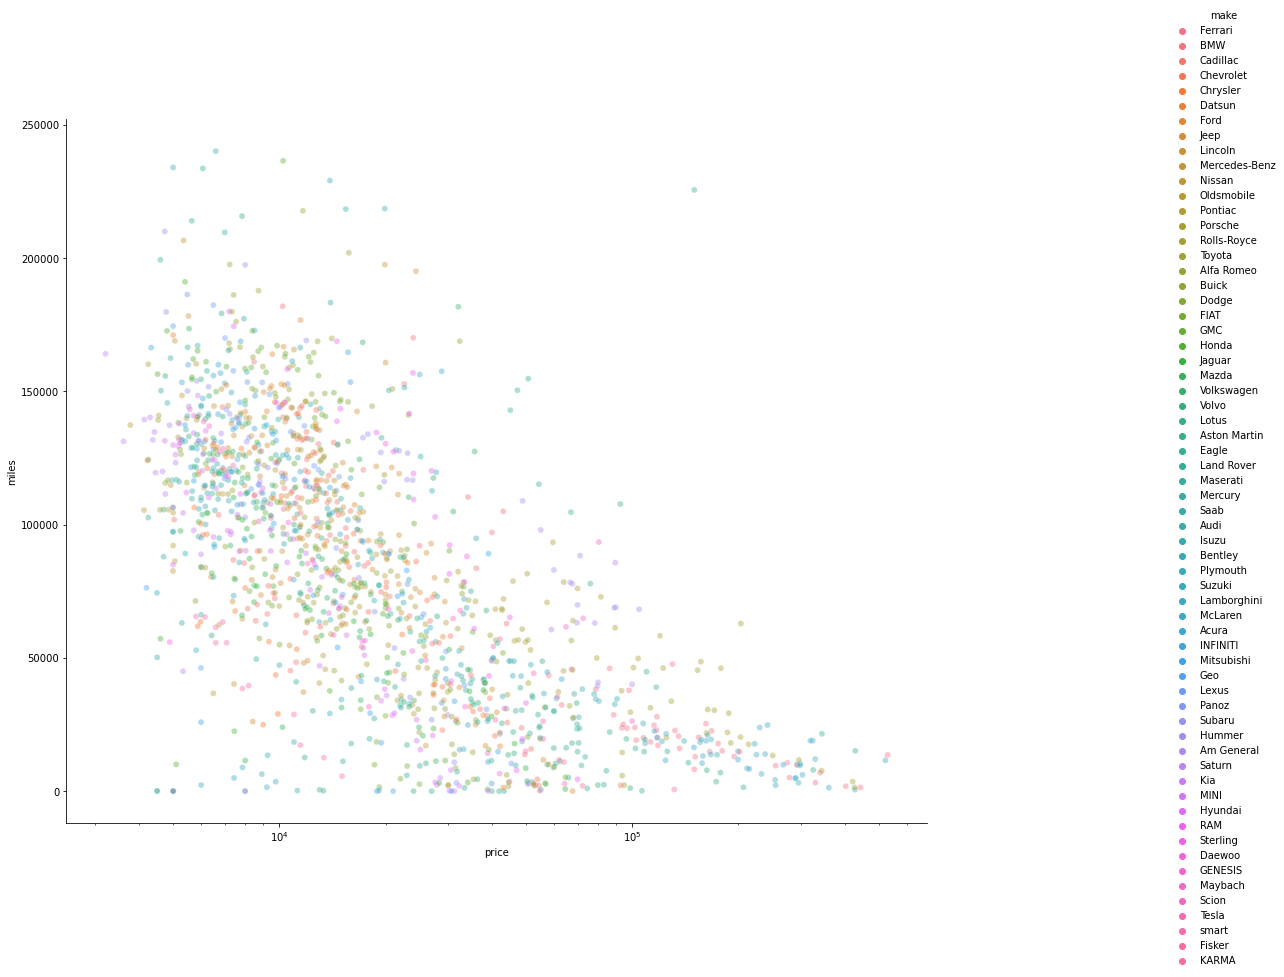

In [52]:
# very busy plot here; I'm going to go ahead and isolate some like-manufacturers in order to visualize some relationships
df_us_new_groupby_make = df_us_n.groupby(['year','make']).mean()
_ = sns.relplot(x="price", y="miles", hue="make", kind = "scatter", alpha = 0.4, data=df_us_new_groupby_make)
_.set(xscale="log")
_.fig.set_figwidth(20)
_.fig.set_figheight(11)
plt.show()

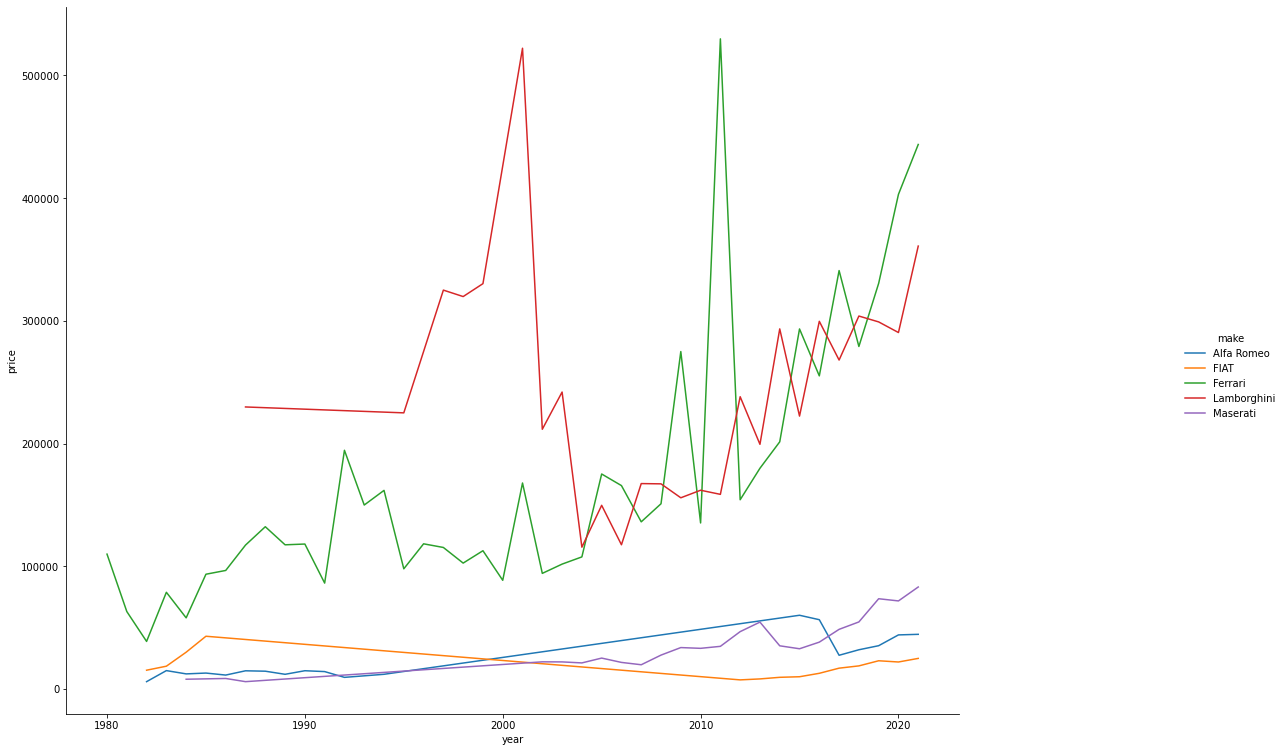

In [53]:
# looking at just Italian makes
df_italy = df_us_n.loc[df_us_n['Country_Origin'] == 'Italy']
italian_makes = list(df_italy["make"].unique())
df_italy = df_us_n.loc[df_us_n['make'].isin(italian_makes)].groupby(['make','year']).mean()
_ = sns.relplot(x="year",y="price",hue='make',data = df_italy, kind = 'line')
_.fig.set_figwidth(20)
_.fig.set_figheight(11)
plt.show()

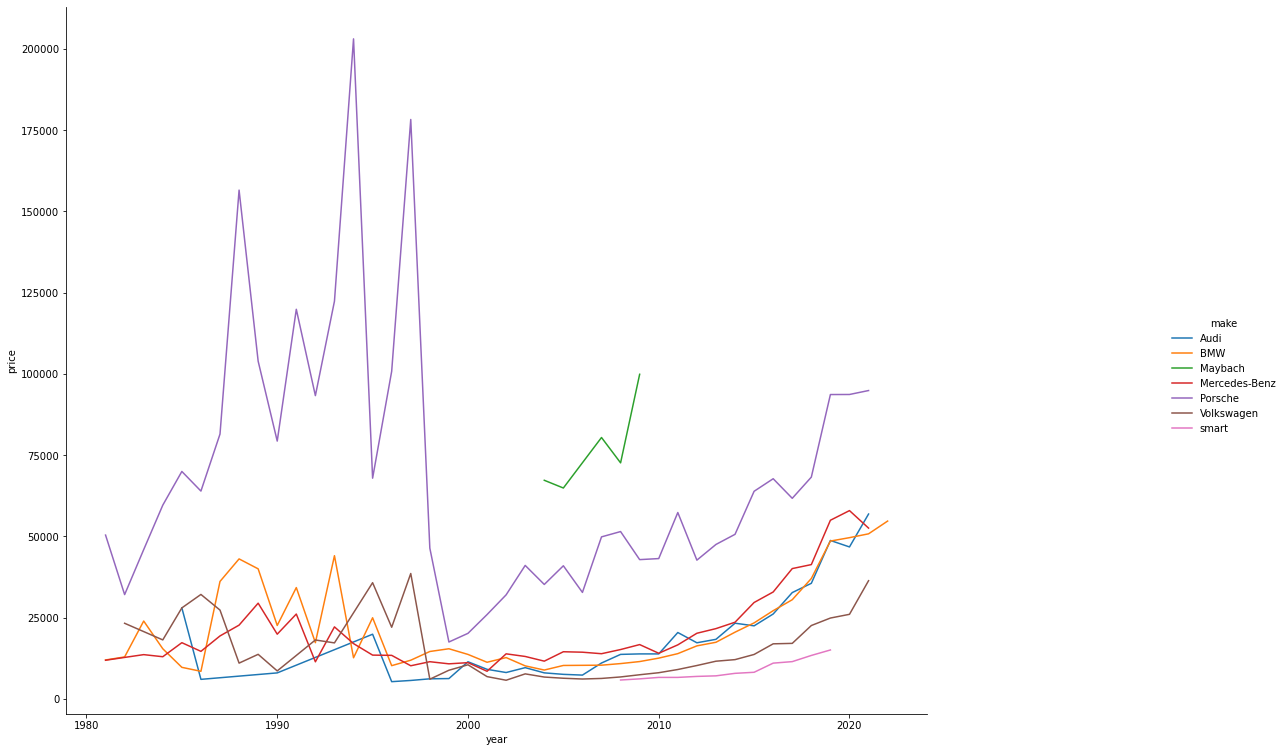

In [54]:
# just looking at the German makes
df_germany = df_us_n.loc[df_us_n['Country_Origin'] == 'Germany']
german_makes = list(df_germany["make"].unique())
df_germany = df_us_n.loc[df_us_n['make'].isin(german_makes)].groupby(['make','year']).mean()
_ = sns.relplot(x="year",y="price",hue='make',data = df_germany, kind = 'line')
_.fig.set_figwidth(20)
_.fig.set_figheight(11)
plt.show()

In [55]:
# as you can tell from the collection of graphs above, there are some interesting trends/trend changes based on the specific model and year
# I'll continue to explore these visualizations, but first, it makes sense to do some hot encoding and imputation

In [56]:
# importing the required libraries for splitting before preprocessing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

In [57]:
# Before any preprocessing steps, I will go ahead and split the data into independent and dependent variables to mitigate
# data leakage; additionally, I will go ahead and split the data into training/testing data sets
X = df_us_n.drop(['price'], axis = 1)
y = df_us_n.price
y.shape

(6447525,)

In [58]:
X.shape

(6447525, 14)

In [61]:
# create a pipeline that helps with chaining the following preprocessing steps: 

# 1. imputation (filling missing categorical values with 'missing'; filling missing miles with -10,000, filling
#    year with 1900 and engine size with 1.0)
# 2. encoding (categorical columns only)
# 3. feature scaling (numeric columns only)

from sklearn.pipeline import (Pipeline, FeatureUnion)
from sklearn.preprocessing import (scale, OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer)
from sklearn.base import TransformerMixin

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

categorical = X.select_dtypes(include=['object','category']).columns
numerical = X.select_dtypes(include=['int64','float64']).columns

# some simple imputation methods that can be applied to the entire dataset since I'm not using any mathematical techniques
# such as applying the mean/median; this will not affect the generalization ability of the training model(s)

X = X.fillna({'miles':-10000,'year':1900,'engine_size':1.0})
X[categorical] = X[categorical].fillna(value='missing')



(4126416, 14)

In [ ]:
# initial split after the imputation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=47)


In [62]:
# confirming the imputation for categorical and numerical values 
null_values = X_train.isnull().sum().sort_values(ascending=False).reset_index()
print(null_values)

             index  0
0   Country_Origin  0
1            state  0
2     engine_block  0
3      engine_size  0
4        fuel_type  0
5     transmission  0
6       drivetrain  0
7     vehicle_type  0
8        body_type  0
9             trim  0
10           model  0
11            make  0
12            year  0
13           miles  0


In [63]:

# scaling the numerical values on the train
min_max_scaler = MinMaxScaler()
X_train_numerical = X_train[numerical]
X_train[numerical] = min_max_scaler.fit_transform(X_train_numerical)

# one hot encoding the cateogorical variables
dummy = pd.get_dummies(X_train[categorical], sparse = True)
dummy.head(5)


,make_Acura,make_Alfa Romeo,make_Am General,make_Aston Martin,make_Audi,make_BMW,make_Bentley,make_Buick,make_Cadillac,make_Chevrolet,...,state_WV,state_WY,state_missing,Country_Origin_America,Country_Origin_England,Country_Origin_Germany,Country_Origin_Italy,Country_Origin_Japan,Country_Origin_South Korea,Country_Origin_Sweden
131530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5521399,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2098197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
569766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2452813,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [64]:
X_train = pd.concat([X_train[numerical], dummy], axis = 1)
X_train.shape

(4126416, 3337)

In [65]:
# looks good/ready for modelling imo
X_train[numerical]

,miles,year,engine_size
131530,0.016503,0.959016,0.156250
5521399,0.015551,0.975410,0.140625
2098197,0.008874,0.959016,0.109375
569766,0.027457,0.934426,0.117188
2452813,0.003632,0.991803,0.195312
...,...,...,...
3069923,0.018386,0.967213,0.414062
4760494,0.015102,0.975410,0.445312
3055675,0.017239,0.983607,0.414062
5649403,0.017868,0.967213,0.187500


In [66]:
# attempt at using the pipeline functionality

# from sklearn.pipeline import (Pipeline, FeatureUnion)
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.base import TransformerMixin

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.pipeline import make_pipeline

# # categorical features
# categorical = X.select_dtypes(include=['object','category']).columns

# # imputing categorical features
# X[categorical] = X[categorical].fillna(value='missing')
    
# # imputing the numerical features
# X = X.fillna({'miles':-10000,'year':1900,'engine_size':1.0})

# # numerical features
# numerical = X.select_dtypes(include=['int64','float64']).columns
# categorical = X.select_dtypes(include=['object','category']).columns
    
# # Defining the column transformer
# t = [('cat', OneHotEncoder(), categorical),('num', MinMaxScaler(), numerical)]
# col_transform = ColumnTransformer(transformers = t)
    
# # Defining the preprocessing pipeline
# full_pipeline = Pipeline(steps = [('prep',col_transform)])

# print(full_pipeline)

In [67]:
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_squared_error

# #  Helper function to calculate RMSE over X folds using Cross-Validation
# def get_RMSE(full_pipeline, X, y, folds):

#     MSE_scores = -1 * cross_val_score(full_pipeline, X, y, cv=folds, scoring='neg_mean_squared_error')
#     RMSE_scores = np.sqrt(MSE_scores)
    
#     return RMSE_scores
  
# #  List the models that we want to evaluate
# models = [
#     RandomForestRegressor(),
#     XGBRegressor(), 
#     LGBMRegressor()
# ]

# print('RMSE Cross-Validation Training Scores \n')

# #  Create the pipeline for each model and evaluate on RMSE
# RMSE = []
# model_names = []
# for i, model in enumerate(models):
    
#     #  This is where we define the pipeline that we created and the model we will use
#     full_pipeline_m = Pipeline(steps=[('pipeline', full_pipeline),
#                                     ('model', model)])

#     #  Fit training data and define number of folds in Cross-Validation
#     RMSE.append(get_RMSE(full_pipeline, X_train, y_train, 5))
    
#     #  Display the scores
#     model_names.append(str(model).split('(')[0])
#     print('{} Training Score: {}'.format(model_names[i], round(np.mean(RMSE[i]),4)))
    
# #  Boxplot to visualize the scores
# plt.figure(figsize=(18,7))
# plt.boxplot(RMSE, labels=model_names, showmeans=True)
# plt.xlabel('Models')
# plt.ylabel('Root Mean Square Error (RMSE)')

In [68]:
# get_RMSE(full_pipeline, X_train, y_train, 5)